In [1]:
import sys
import os
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad
import torch.nn.functional as F

sys.path.append('../python')

import models
from models import FashionCNN


sys.path.append('..')

In [4]:
import torchvision 
import torchvision.transforms as tt
from torchvision.datasets import FashionMNIST


data_dir='../data'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

# run below only if you want to claculate the mean and std, but I already did
# print("Downloading FashionMNIST data...")
# fashion_train = FashionMNIST(data_dir, train=True, download=True)
fashion_test = FashionMNIST(data_dir, train=False, download=True)

# train_long=torch.stack([tt.ToTensor()(im).view(-1) for im,_ in fashion_train])
# test_long=torch.stack([tt.ToTensor()(im).view(-1) for im,_ in fashion_test])


# train_mean = torch.mean(train_long)
# train_std = torch.std(train_long)
# test_mean = torch.mean(test_long)
# test_std = torch.std(test_long)

train_mean = 0.2860
train_std = 0.3530
test_mean = 0.2868
test_std = 0.3524

test_transform=tt.Compose([
    tt.ToTensor(), 
    tt.Normalize(mean=(test_mean,),std=(test_std,))
])

train_null_transform = tt.Compose([
    tt.ToTensor(), 
    tt.Normalize(mean=(train_mean,),std=(train_std,))
])

train_trans_transform = tt.Compose([
    tt.RandomAffine(degrees=0, translate=(0.5, 0.5)),
    tt.ToTensor(), 
    tt.Normalize(mean=(train_mean,),std=(train_std,))
])

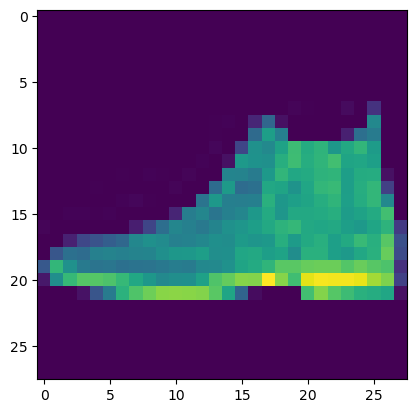

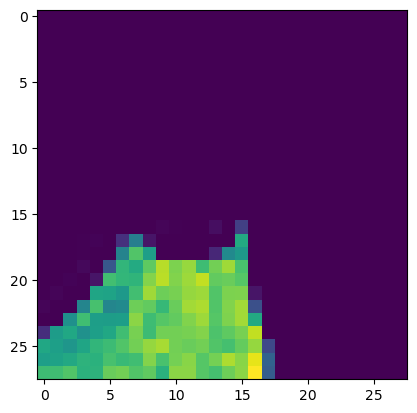

In [5]:
plt.imshow(fashion_test[0][0])
plt.show()
plt.imshow(tt.RandomAffine(degrees=0, translate=(0.5, 0.5))(fashion_test[0][0]))
plt.show()

In [8]:
len(test_loader)

313

In [12]:
LR=0.1
WD=1e-3
epochs=10


fashion_train = FashionMNIST(data_dir, train=True, download=True, transform=train_trans_transform)
fashion_test = FashionMNIST(data_dir, train=False, download=True, transform=test_transform)

train_loader=DataLoader(fashion_train,shuffle=True, batch_size=32)
test_loader=DataLoader(fashion_test,shuffle=False, batch_size=32)


model = FashionCNN()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)

for epoch in range(epochs):
    print(epoch)
    model.train()

    epoc_loss=0.0
    for img,lbl in train_loader:
        optimizer.zero_grad()
        pred = model(img)
        loss = F.cross_entropy(pred,lbl)
        epoc_loss+=loss.item()
        loss.backward()
        optimizer.step()
    epoc_loss/=len(train_loader)

    model.eval()
    epoch_val_loss=0.0
    correct=0.0
    total=0
    for img,lbl in test_loader:
        pred = model(img)
        loss = F.cross_entropy(pred,lbl)
        epoch_val_loss+=loss.item()
        
        pred = pred.argmax(dim=1, keepdim=True)
        correct+= (pred.argmax(dim=1) == lbl).type(torch.float).sum().item()
        total += lbl.size(0)

        
    epoch_val_loss/=len(test_loader)
    correct/=total
    print(f'epoch: {epoch} | train loss: {epoc_loss} | val loss: {epoch_val_loss} | acc: {100*correct:.2f}')

0
epoch: 0 | train loss: 2.4692426465352377 | val loss: 2.3025851257312033 | acc: 10.00
1
epoch: 1 | train loss: 2.3025851249694824 | val loss: 2.3025851257312033 | acc: 10.00
2
